In [48]:
load("ProcessData.RData")
library(ggplot2)
library(dplyr)
library(tidyr)
library(tidyverse)
library(sigfit)
combined_df <- subset(combined_df, unique_SNVs > 500)
Hiatt <- subset(Hiatt, unique_SNVs > 500)
LeeSix <- subset(LeeSix, unique_SNVs > 500)





FALSE 
  417 

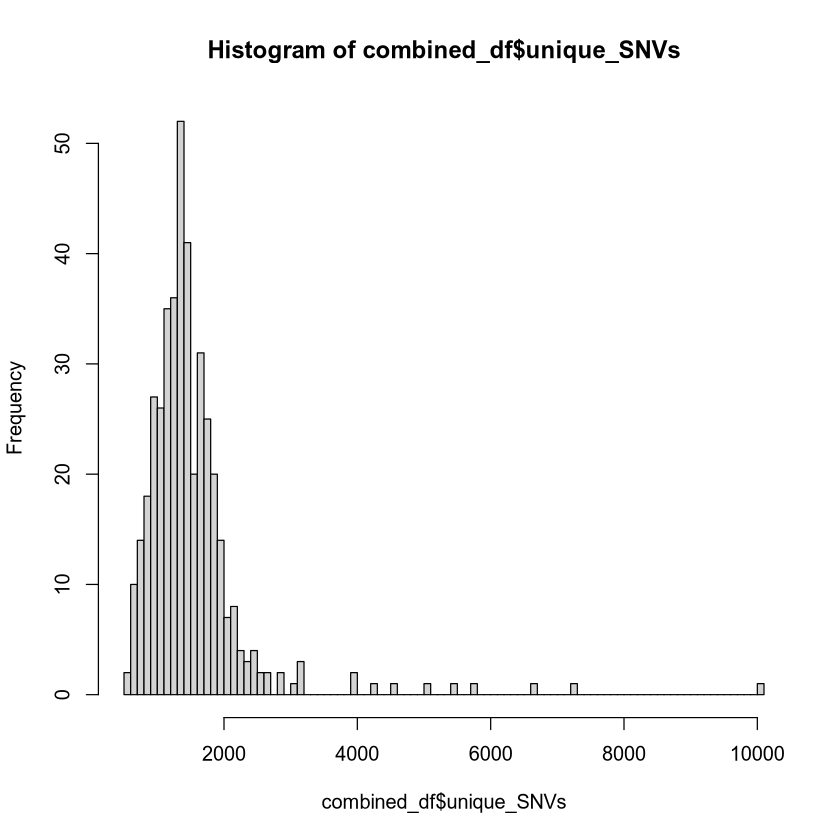

In [35]:
table(combined_df$unique_SNVs < 500)
hist(combined_df$unique_SNVs, breaks = 100)

In [ ]:
library(MASS)
library(stringr)
library(cowplot)
library(forcats)
library(patchwork)
library(ggnewscale)
library(RColorBrewer)
library(rstatix)
library(readr)
library(mutspecdist)


Figure 2: 
**Hiatt*** vs combine?


Part 1: SNV/Indel by age
Biological age-effect of SNVs 
SNV/indel burden with age (boxplot corrected by age) 
Transition/transversion
Compare per year aggregation? (Look at Lynch paper) 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


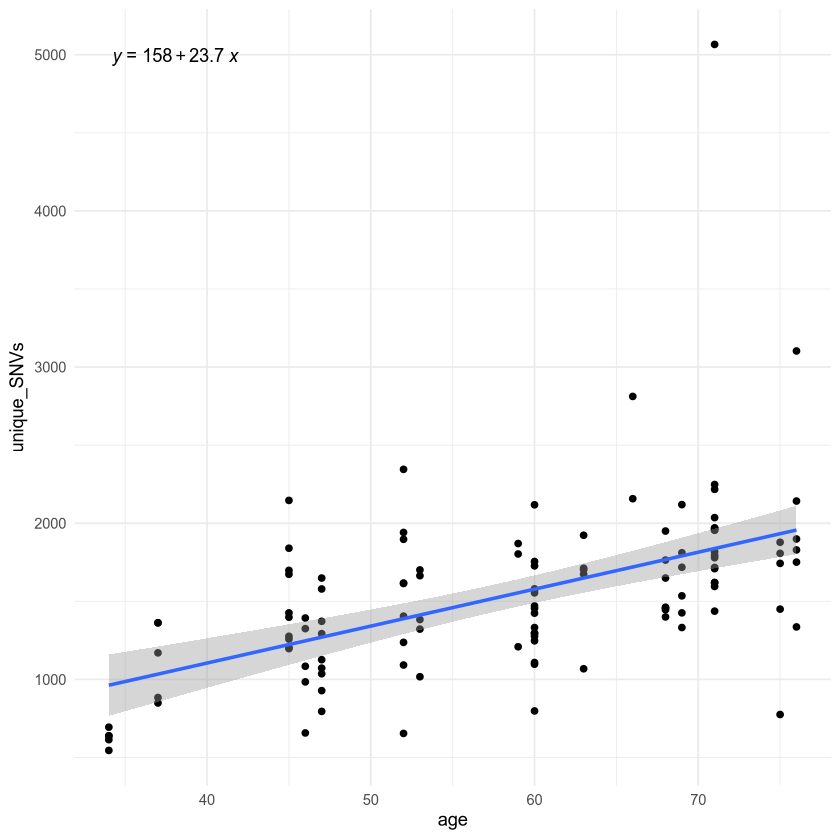

`geom_smooth()` using formula = 'y ~ x'


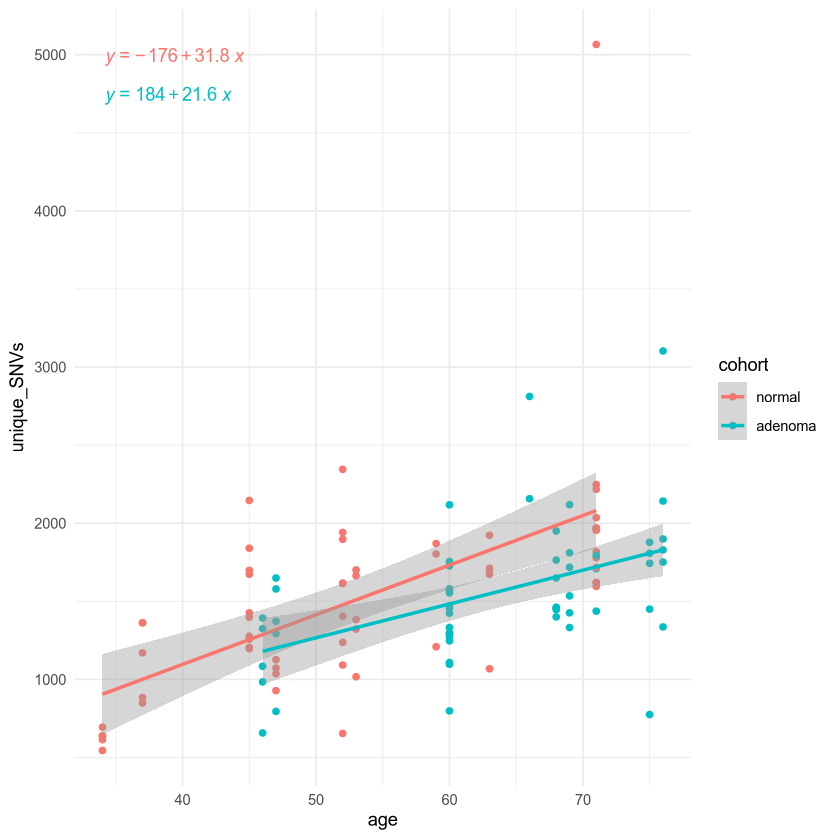

`geom_smooth()` using formula = 'y ~ x'


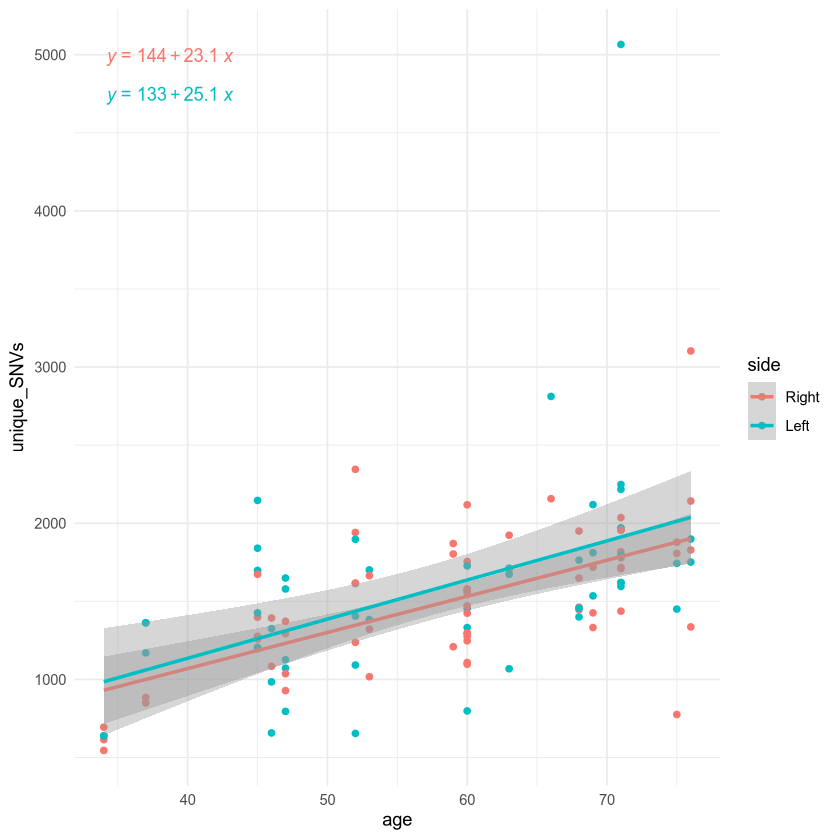

`geom_smooth()` using formula = 'y ~ x'


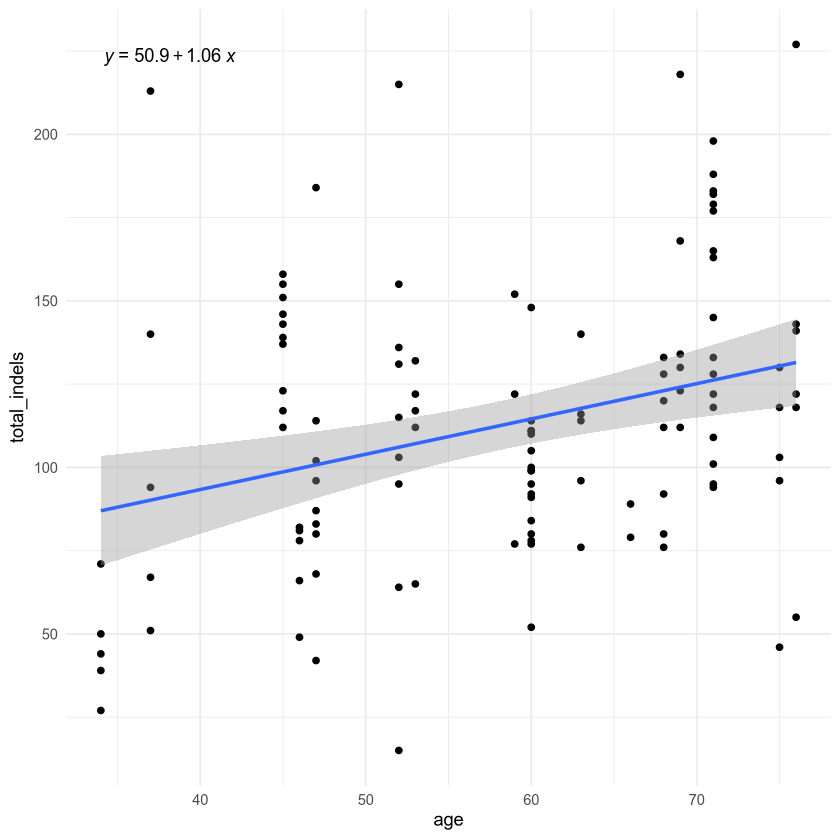

`geom_smooth()` using formula = 'y ~ x'


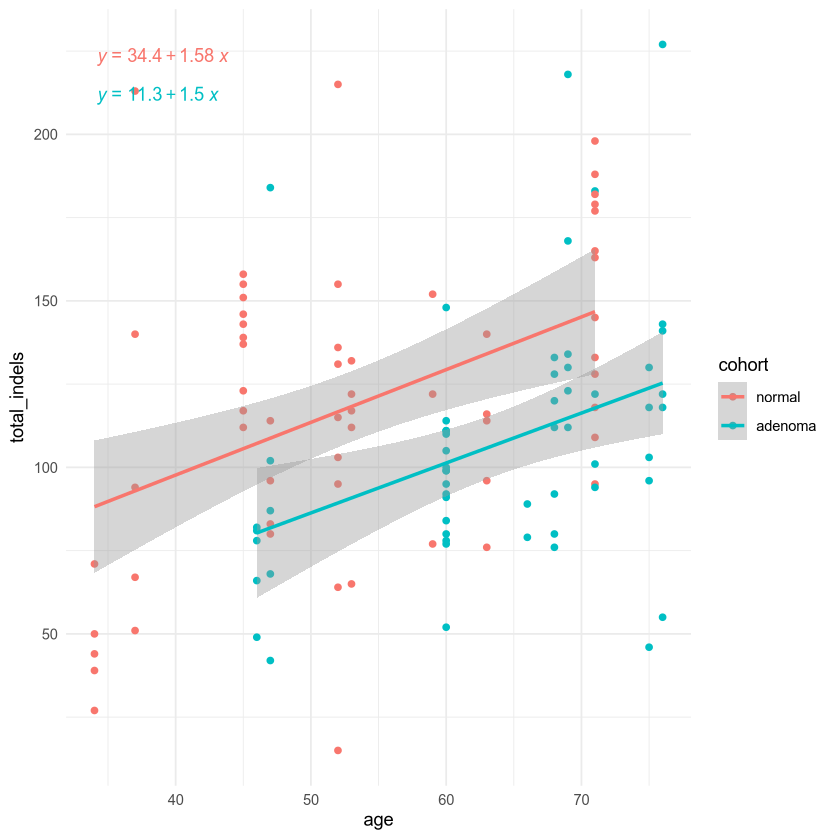

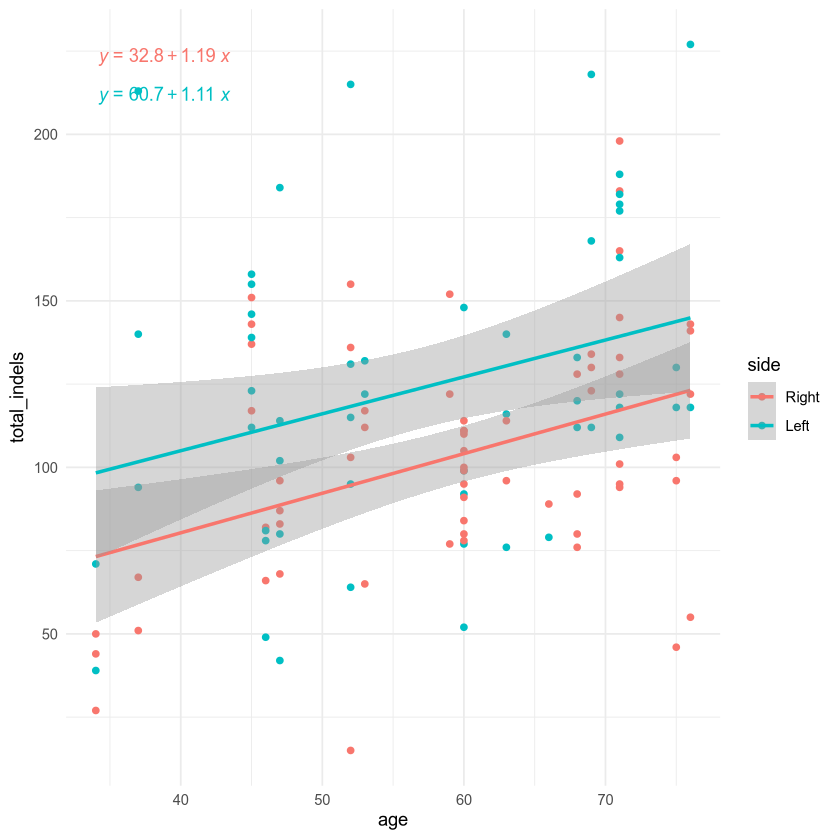

In [40]:
ggplot(Hiatt, aes(x = age, y = unique_SNVs)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = unique_SNVs, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = unique_SNVs, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Orientation is not uniquely specified when both the x and y aesthetics are
continuous. Picking default orientation 'x'.”


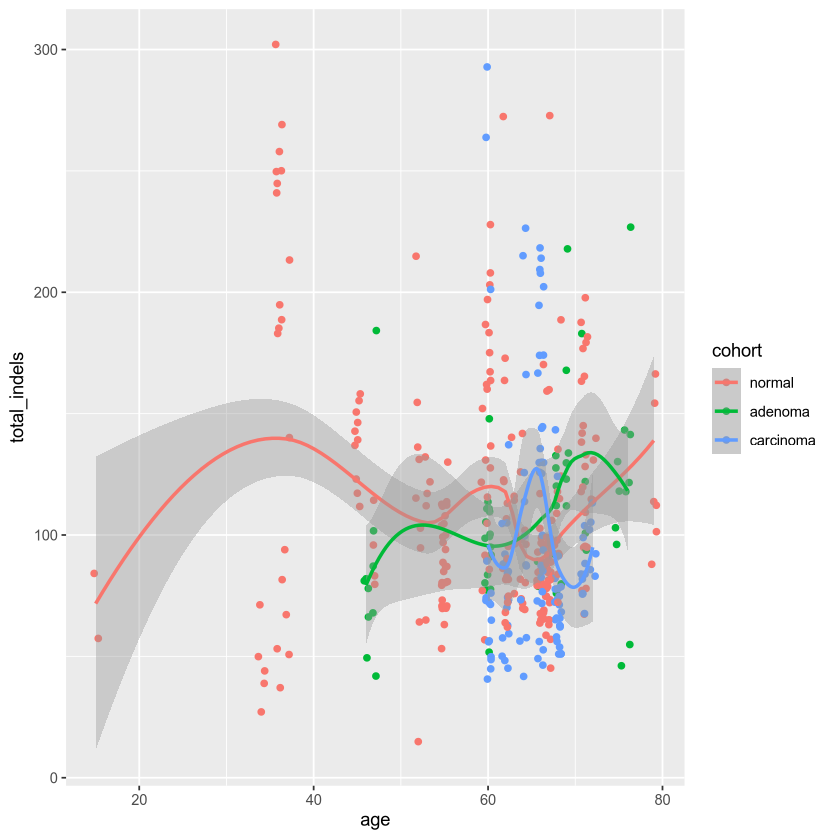

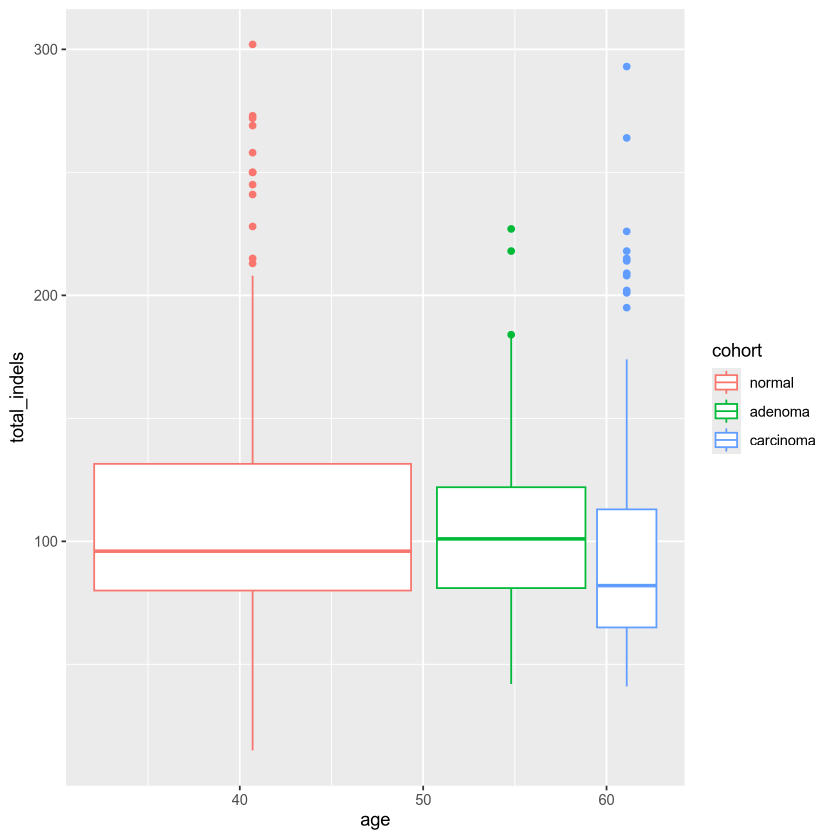

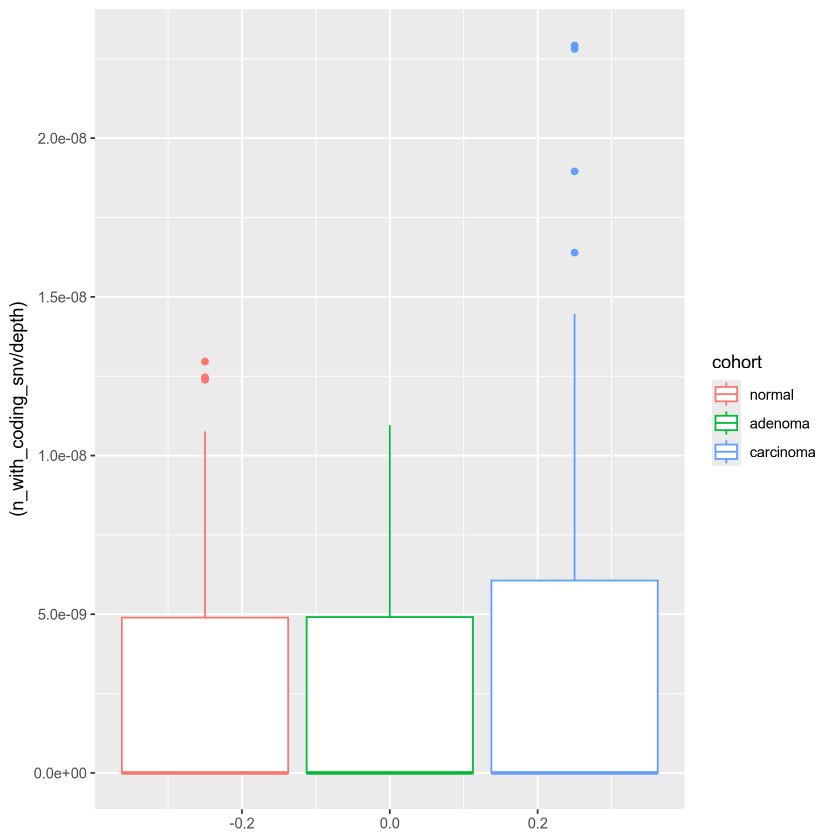

In [31]:
ggplot(combined_df) + geom_jitter(aes(x=age, y=total_indels, color = cohort)) + geom_smooth(aes(x=age, y=total_indels, color = cohort))

ggplot(combined_df) + geom_boxplot(aes(x=age, y=total_indels, color = cohort))

ggplot(combined_df) + geom_boxplot(aes(y=(n_with_coding_snv/depth), color = cohort))


Mean trend by region

Part 2: Spectra + AMSD
SUBTYPES: Stacked bar of subtypes? 


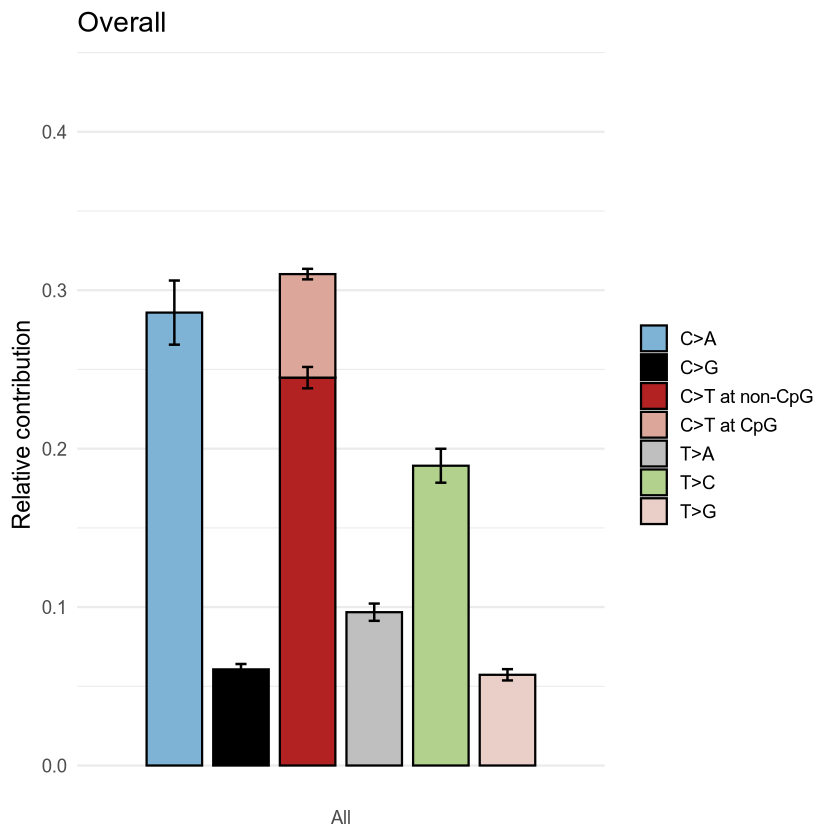

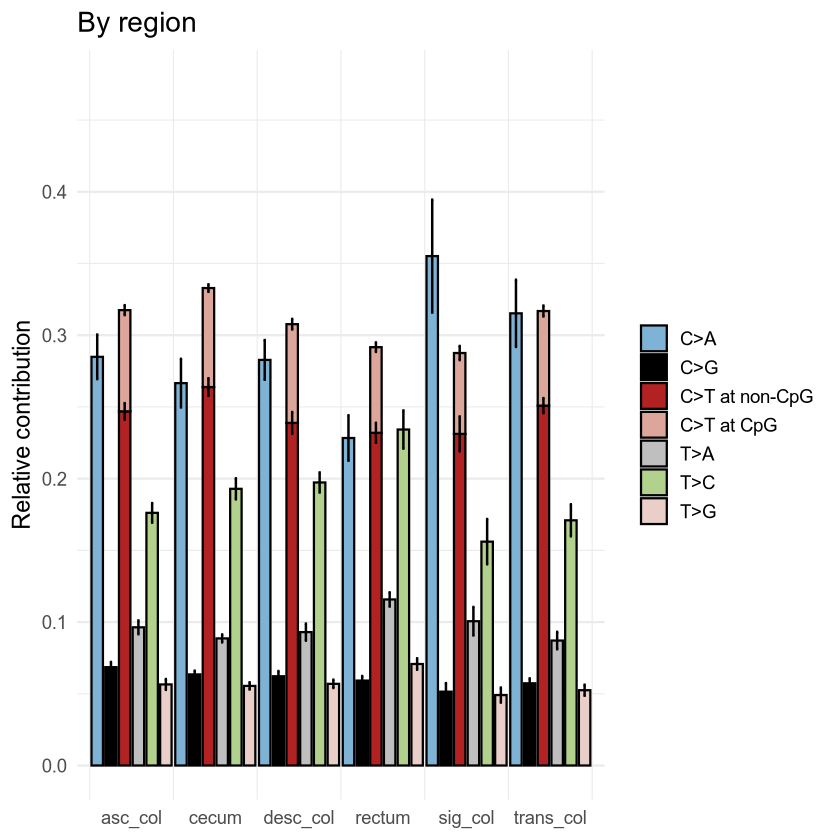

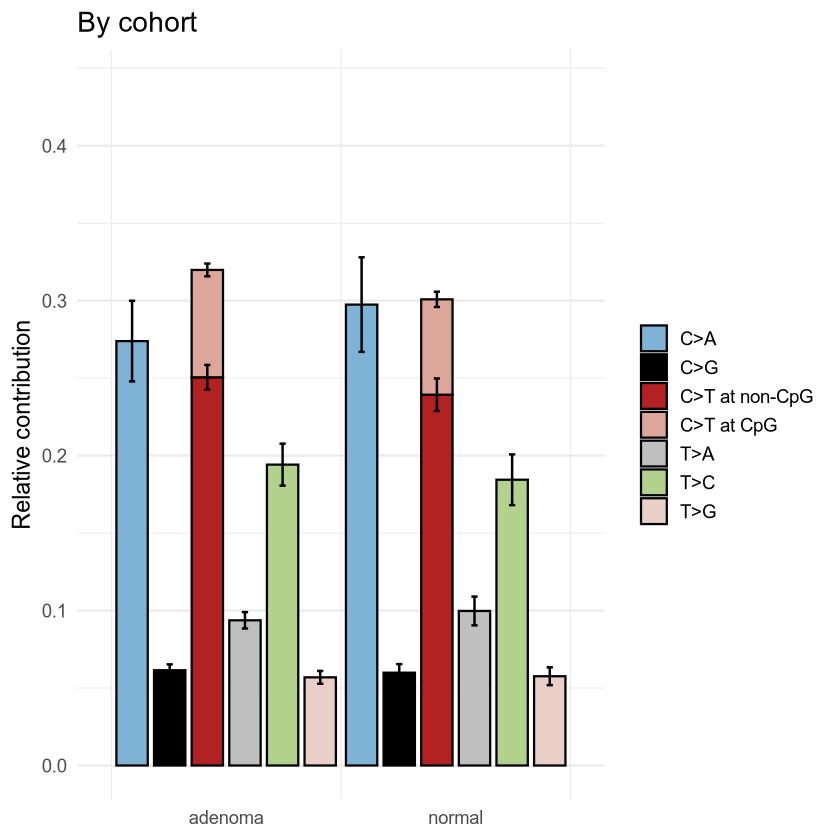

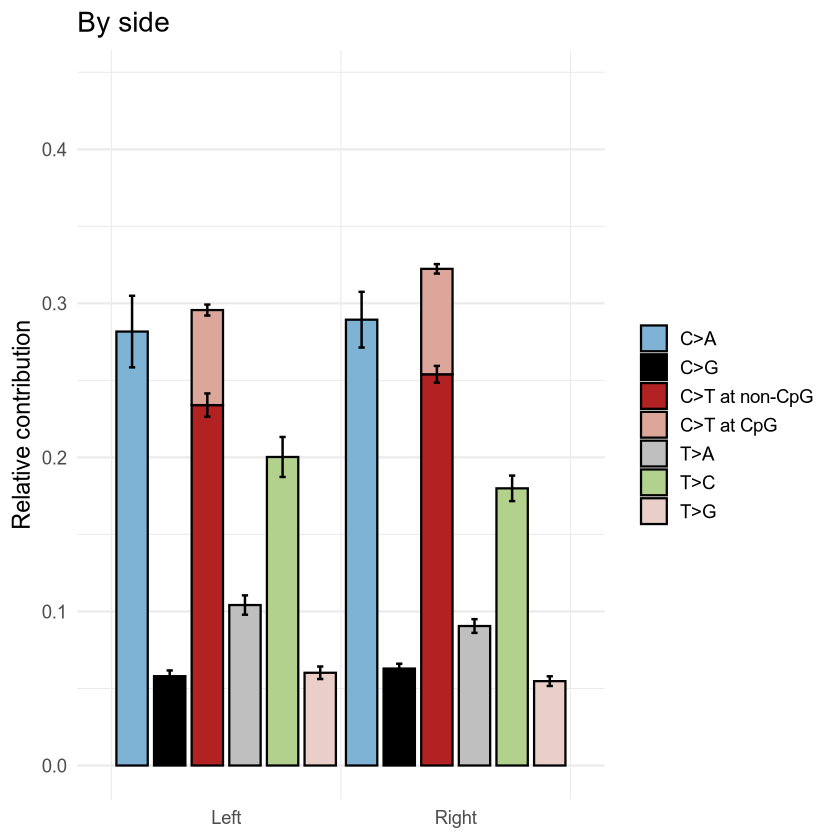

In [42]:
df <- Hiatt %>%
  mutate(
    C.T_nonCpG = `C.T` - CpG,
    C.T_CpG    = CpG
  ) %>%
  mutate(across(c(C.A, C.G, C.T_nonCpG, C.T_CpG, T.A, T.C, T.G, unique_SNVs), as.numeric))

mut_map <- tibble(
  label = c("C>A","C>G","C>T at non-CpG","C>T at CpG","T>A","T>C","T>G"),
  col   = c("C.A","C.G","C.T_nonCpG","C.T_CpG","T.A","T.C","T.G")
)

long <- df %>%
  pivot_longer(all_of(mut_map$col), names_to = "mut_col", values_to = "count") %>%
  left_join(mut_map, by = c("mut_col" = "col")) %>%
  mutate(prop = count / unique_SNVs)

# ---------------------------
# 2) Summary: mean & SE per group
# ---------------------------
summarise_group <- function(long_df, group_var = NULL) {
  if (is.null(group_var)) {
    long_df %>%
      group_by(label) %>%
      summarise(n = n_distinct(donor),
                mean_prop = mean(prop, na.rm = TRUE),
                se_prop = sd(prop, na.rm = TRUE) / sqrt(n),
                .groups = "drop") %>%
      mutate(group = "All")
  } else {
    long_df %>%
      group_by(!!sym(group_var), label) %>%
      summarise(n = n_distinct(donor),
                mean_prop = mean(prop, na.rm = TRUE),
                se_prop = sd(prop, na.rm = TRUE) / sqrt(n),
                .groups = "drop") %>%
      rename(group = !!sym(group_var))
  }
}

# ---------------------------
# 3) Plotting function: errorbars at ymin + mean_prop ± se_prop
# ---------------------------
plot_grouped_ct_stack_final <- function(summary_df,
                                        plot_title = "Plot",
                                        out_file = NULL,
                                        bar_halfwidth = 0.20,
                                        inner_gap = 0.08,
                                        cluster_pad = 0.30) {

  label_order <- mut_map$label

  # ensure label & group ordering
  summary_df <- summary_df %>%
    mutate(label = factor(label, levels = label_order),
           group = as.character(group)) %>%
    mutate(group = factor(group, levels = sort(unique(group))))

  # base_x per group
  groups <- levels(summary_df$group)
  G <- length(groups)
  base_df <- tibble(group = groups, base_x = seq_len(G))

  # slots: C>T share same slot index
  label_slots <- tibble(
    label = label_order,
    slot_index = c(1,2,3,3,4,5,6)
  )

  slot_width <- 2*bar_halfwidth + inner_gap
  max_slot <- max(label_slots$slot_index)
  slot_positions <- (label_slots$slot_index - (max_slot + 1)/2) * slot_width
  names(slot_positions) <- label_slots$label

  cluster_spacing <- max(slot_width * (max_slot + 0.1), 2*bar_halfwidth + cluster_pad)

  # compute positions
  plotdat <- summary_df %>%
    left_join(base_df, by = "group") %>%
    mutate(offset = slot_positions[as.character(label)],
           x = base_x * cluster_spacing + offset) %>%
    arrange(base_x, x, label)

  # stacking per x
  plotdat <- plotdat %>%
    group_by(group, x) %>%
    mutate(
      ymax = cumsum(mean_prop),
      ymin = lag(ymax, default = 0)
    ) %>%
    ungroup() %>%
    # compute the errorbar center and limits at ymin + mean_prop ± se_prop
    mutate(
      eb_center = ymin + mean_prop,        # top of the segment (absolute)
      eb_ymin   = eb_center - se_prop,
      eb_ymax   = eb_center + se_prop
    )

  # palette
  palette <- c(
    "C>A"="#7fb3d5","C>G"="#000000",
    "C>T at non-CpG"="#b22222","C>T at CpG"="#dca79a",
    "T>A"="#bfbfbf","T>C"="#b2d18c","T>G"="#e9cfc8"
  )

  # draw: geom_rect for bars, geom_errorbar using eb_ymin/eb_ymax
  p <- ggplot() +
    geom_rect(data = plotdat,
              aes(xmin = x - bar_halfwidth, xmax = x + bar_halfwidth,
                  ymin = ymin, ymax = ymax, fill = label),
              color = "black") +

    geom_errorbar(data = plotdat,
                  aes(x = x, ymin = eb_ymin, ymax = eb_ymax),
                  width = bar_halfwidth * 0.4, size = 0.7, color = "black") +

    scale_fill_manual(values = palette, breaks = mut_map$label) +

    scale_x_continuous(breaks = (base_df$base_x * cluster_spacing),
                       labels = base_df$group,
                       expand = expansion(add = 0.5)) +

    labs(x = NULL, y = "Relative contribution", title = plot_title, fill = NULL) +

    theme_minimal(base_size = 14) +
    theme(axis.text.x = element_text(size = 11),
          legend.position = "right",
          panel.grid.major.x = element_blank()) +

    coord_cartesian(ylim = c(0, max(plotdat$ymax) + 0.12))

  print(p)
  if (!is.null(out_file)) ggsave(out_file, p, width = max(6, G * 1.0), height = 5, dpi = 300)

  invisible(list(plot = p, plotdat = plotdat))
}

# ---------------------------
# 4) Create & save plots
# ---------------------------
overall_summary <- summarise_group(long, NULL)
plot_grouped_ct_stack_final(overall_summary, plot_title = "Overall", out_file = "plots/mutation_overall_ctstack_final2.png")

region_summary <- summarise_group(long, "region")
plot_grouped_ct_stack_final(region_summary, plot_title = "By region", out_file = "plots/mutation_by_region_ctstack_final2.png")

cohort_summary <- summarise_group(long, "cohort")
plot_grouped_ct_stack_final(cohort_summary, plot_title = "By cohort", out_file = "plots/mutation_by_cohort_ctstack_final2.png")

side_summary <- summarise_group(long, "side")
plot_grouped_ct_stack_final(side_summary, plot_title = "By side", out_file = "plots/mutation_by_side_ctstack_final2.png")

In [43]:
amsd <- function(set1,
                set2,
                mean_or_sum = "mean",  # or "sum"
                n_sim = 1000,
                seed = NULL) {
  tol <- 1e-8
  # Validate inputs
  if (!is.matrix(set1) && !is.data.frame(set1)) stop("set1 must be a matrix or data.frame")
  if (!is.matrix(set2) && !is.data.frame(set2)) stop("set2 must be a matrix or data.frame")

  if (!mean_or_sum %in% c("mean", "sum")) {
    stop("Argument 'mean_or_sum' must be either 'mean' or 'sum'")
  }

  if (mean_or_sum == "mean" & max(c(rowSums(set1), rowSums(set2))) - 1 > tol) {
    stop("Spectra fractions should add up to 1 when running 'mean_or_sum' = 'mean'")
  }

  if (mean_or_sum == "sum" & max(c(rowSums(set1), rowSums(set2)) <= 1)) {
    stop("Run 'mean_or_sum' = 'mean' for fractional mutation spectra that add up to 1")
  }

  # Define aggregation function
  aggragate_spectra <- if (mean_or_sum == "mean") {
    function(data) colMeans(data, na.rm = TRUE)
  } else {
    function(data) colSums(data, na.rm = TRUE)
  }


  # Compute observed distance
  spectra1 <- aggragate_spectra(set1)
  spectra2 <- aggragate_spectra(set2)
  observed_distance <- cosine_dist(spectra1, spectra2)[[1]]

  # Prepare permutation dataset
  combined_set <- rbind(set1, set2)

  # Run permutations
  set.seed(seed)
  dist_rands <- numeric(n_sim)
  group_size <- nrow(set1)

  for (k in seq_len(n_sim)) {
    indices <- sample(seq_len(nrow(combined_set)), group_size)
    spectra_group1 <- aggragate_spectra(combined_set[indices, , drop = FALSE])
    spectra_group2 <- aggragate_spectra(combined_set[-indices, , drop = FALSE])
    dist_rands[k] <- cosine_dist(spectra_group1, spectra_group2)[[1]]
  }

  # Calculate p-value
  p_value <- max(c(mean(dist_rands >= observed_distance), 1 / n_sim))

  # Return output
  return(list(cosine = observed_distance, p = p_value, sims = dist_rands))
}

In [47]:
# Read the matrix
matrix <- read.table(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS6.all",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE,
  check.names = FALSE
)

convert_mutation <- function(x) {
  # Extract the left base, ref>alt, and right base
  left <- str_sub(x, 1, 1)
  middle <- str_extract(x, "(?<=\\[).+?(?=\\])")  # grabs C>A etc
  right <- str_sub(x, -1, -1)

  # Split ref>alt into two
  ref_alt <- str_split(middle, ">", simplify = TRUE)

  # Construct new notation
  paste0(left, ref_alt[1], right, ">", left, ref_alt[2], right)
}

# Apply to dataframe
matrix <- matrix %>%
  mutate(MutationType = sapply(MutationType, convert_mutation))

v3.4 <- v3.4 %>%
  mutate(Type = sapply(Type, convert_mutation))

v3.4switched <- t(as.data.frame(v3.4[-1]))

colnames(v3.4switched) <- v3.4$Type

matrixswitched <- t(as.data.frame(matrix[-1]))

colnames(matrixswitched) <- matrix$MutationType
rownames(matrixswitched) <- gsub("X", "", rownames(matrixswitched))
matrixswitched <- matrixswitched[!(row.names(matrixswitched) %in% rows_to_remove), ]

ERROR: Error: object 'v3.4' not found


In [ ]:
Right <- subset(Hiatt_novaf, side == 'Right')
Left <- subset(Hiatt_novaf, side == "Left")

Right_list <- Right$crypt_sample
Left_list <- Left$crypt_sample

Right <- matrixswitched[rownames(matrixswitched) %in% Right_list, ]
Left <- matrixswitched[rownames(matrixswitched) %in% Left_list, ]

df_Hiatt <- df_Hiatt[!(row.names(df_Hiatt) %in% lowcov), ]

df_LScrypt <- df_LeeSix[!(row.names(df_LeeSix) %in% HLS), ]

df_Hiatt <- as.data.frame(df_Hiatt) / rowSums(as.data.frame(df_Hiatt))

# make sure Hiatt samples are here...
matrixswitched_prop <- matrixswitched / rowSums(matrixswitched)
matrixswitched_prop <- as.data.frame(matrixswitched_prop)
df_Hiatt <- matrixswitched_prop[rownames(matrixswitched_prop) %in% Hiatt_list, ]
df_LeeSix <- matrixswitched_prop[rownames(matrixswitched_prop) %in% LeeSix_list, ]

#df_Hiatt <- df_Hiatt %>%
#  tibble::rownames_to_column(var = "crypt_subject")

matrix <- merge(matrixswitched_prop, combined_df, by = "crypt_sample")

Right <- as.data.frame(Right)/rowSums(as.data.frame(Right))
Left <- as.data.frame(Left)/rowSums(as.data.frame(Left))

#run ASMD
exp_v_con <- amsd(Right,
                  Left,
                  mean_or_sum = "mean",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)

# Run with with “sum” option on mutation counts rather than mutation type
# fractions, which changes the permutation cosine distance distribution, but
# not the p-value, indicating the result is not driven by high- or low-mutation
# outliers

LScell <- as.data.frame(df_LScell) / rowSums(as.data.frame(df_LScell))

LScrypt <- as.data.frame(df_LScrypt) / rowSums(as.data.frame(df_LScrypt))

exp_v_con <- amsd(LScell,
                  LScrypt,
                  mean_or_sum = "sum",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)

Subtype waterfall?

In [ ]:
make_clean_mutation_df <- function(df) {
  df %>%
    mutate(
      Non_CpG_CT   = C.T - CpG,
      sum_mut_types = C.A + C.G + CpG + Non_CpG_CT + T.A + T.C + T.G,
      diff = sum_mut_types - unique_SNVs
    ) %>%
    arrange(region, desc(sum_mut_types)) %>%   # sort within region
    group_by(region) %>%
    mutate(
      region_rank = row_number()
    ) %>%
    ungroup()
}

Hiatt_clean2 <- make_clean_mutation_df(Hiatt_clean)

ggplot(Hiatt_clean2, aes(x = region_rank, y = 3.1*(unique_SNVs/depth_scaled))) +
  geom_col() +
  facet_grid(~ region, scales = "free_x", space = "free_x") +
  theme_bw() +
  theme(
    strip.background = element_rect(fill = "grey90"),
    strip.text = element_text(face = "bold")
  ) + ylim(0,6000)



In [ ]:
make_mutation_burden_and_activity <- function(df, region_order) {

  # --- Define mutation types ---
  df <- df %>%
    mutate(
      Non_CpG_CT = C.T - CpG,
      total_SNVs = C.A + C.G + CpG + Non_CpG_CT + T.A + T.C + T.G,
      region = factor(region, levels = region_order)
    )

  mut_types <- c("C.A","C.G","CpG","Non_CpG_CT","T.A","T.C","T.G")

  # --- Sort samples by region ---
  df <- df %>%
    arrange(region, cohort, crypt_sample) %>%
    mutate(xid = paste(cohort, region, crypt_sample, sep = "_"),
           xid = factor(xid, levels = unique(xid)))

  # --- Long format ---
  df_long <- df %>%
    select(crypt_sample, region, cohort, all_of(mut_types), total_SNVs, xid) %>%
    pivot_longer(
      cols = all_of(mut_types),
      names_to = "mut_type",
      values_to = "count"
    ) %>%
    mutate(prop = count / total_SNVs)

  # --- Colors ---
  mut_colors <- c(
    "C.A"        = "#7BC8A4",
    "C.G"        = "#F1D354",
    "CpG"        = "#C3B1E1",
    "Non_CpG_CT" = "#EB564B",
    "T.A"        = "#4A90E2",
    "T.C"        = "#F5A623",
    "T.G"        = "#8CC751"
  )

  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  # --- Region strip: one tile per crypt_sample with region color ---
  df_region_strip <- df %>%
    mutate(y = 1.05,  # above proportion bars
           y_count = max(df_long$total_SNVs) + max(df_long$total_SNVs)*0.05)  # above count bars

  # ===========================================================
  # PANEL B — Mutation Burden
  # ===========================================================
  max_count <- max(df_long$total_SNVs)

  p_burden <- ggplot() +
    geom_col(data = df_long, aes(x = xid, y = count, fill = mut_type), width = 1) +
    geom_tile(data = df_region_strip,
              aes(x = xid, y = y_count, fill = region),
              width = 1, height = max_count*0.03) +
    scale_fill_manual(values = c(mut_colors, region_colors), name = "Mutation Type / Region") +
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x  = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text   = element_text(size = 12, face = "bold")
    ) +
    ylab("Mutation Burden") +
    xlab("") +
    ggtitle("Mutation Burden (counts)")

  # ===========================================================
  # PANEL C — Mutation Activity
  # ===========================================================
  p_activity <- ggplot() +
    geom_col(data = df_long, aes(x = xid, y = prop, fill = mut_type), width = 1) +
    geom_tile(data = df_region_strip,
              aes(x = xid, y = y, fill = region),
              width = 1, height = 0.03) +
    scale_fill_manual(values = c(mut_colors, region_colors), name = "Mutation Type / Region") +
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x  = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text   = element_text(size = 12, face = "bold")
    ) +
    ylab("Mutation Activity (proportion)") +
    xlab("") +
    ggtitle("Mutation Activity (proportion)")

  return(list(burden = p_burden, activity = p_activity))
}

# Example usage
region_order <- c("Right", "cecum", "asc_col", "trans_col",
                  "desc_col", "sig_col", "rectum", "Left")

plots <- make_mutation_burden_and_activity(Hiatt_clean, region_order)
p_burden   <- plots$burden
p_activity <- plots$activity

p_burden
p_activity


Part 3: MSI
Maybe compare MSI with SBS88?

In [ ]:
instability = read.csv('/Users/quinlan/Documents/SEMIColon/instability.tsv',
                       stringsAsFactors = FALSE, header = TRUE, sep = "\t")

#colnames(instability)[1] <- "crypt_sample"

#combined_instability <- merge(sample_summary, combined_df, by = "crypt_sample")

#ggplot(df_long, aes(x=value)) + geom_histogram() + xlim(0,5)

mean_threshold <- 2.2569
median_threshold <- 3

# Function to split value and haplogroup
split_value_hap <- function(x) {
  tibble(
    value = as.numeric(str_extract(x, "^[0-9.]+")),
    haplogroup = as.integer(str_extract(x, "(?<=\\()\\d+(?=\\))"))
  )
}

# Convert to long format and parse
df_long <- instability %>%
  pivot_longer(-Sample, names_to = "locus_measure", values_to = "raw") %>%
  rowwise() %>%
  mutate(
    value = split_value_hap(raw)$value,
    haplogroup = split_value_hap(raw)$haplogroup,
    measure = ifelse(str_detect(locus_measure, "mean_ad"), "mean", "median"),
    locus = str_extract(locus_measure, "X[0-9.]+\\.[TA]")
  ) %>%
  select(-raw)

# Determine if value exceeds threshold
df_long <- df_long %>%
  mutate(
    instable_mean   = ifelse(measure == "mean", value > mean_threshold, NA),
    instable_median = ifelse(measure == "median", value > median_threshold, NA)
  )

#instability_mean <- subset(df_long_hiatt, measure == "mean")
#mean_values <- instability_mean$value
#instability_median <- subset(df_long_hiatt, measure == "median")
#median_values <- instability_median$value

#mean_threshold <- quantile(mean_values, 0.95, na.rm = TRUE)   # 95th percentile
#median_threshold <- quantile(median_values, 0.95, na.rm = TRUE)
#mean_threshold: 2.2569
#median_threshold: 3

# Plot instability for mean only
ggplot(df_long %>% filter(measure == "mean"), aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  geom_vline(xintercept = mean_threshold, color = "red", linetype = "dashed") +
  labs(title = "Mean values with instability threshold") + xlim(0,10)

# Plot instability for median only
ggplot(df_long %>% filter(measure == "median"), aes(x = value)) +
  geom_histogram(bins = 30, fill = "darkgreen") +
  geom_vline(xintercept = median_threshold, color = "red", linetype = "dashed") +
  labs(title = "Median values with instability threshold") + xlim(0,10)

# Aggregate per locus: mean and median must both be instable for haplogroup
locus_summary <- df_long %>%
  group_by(Sample, locus, haplogroup) %>%
  summarise(
    haplo_instable = all(c(
      instable_mean[measure == "mean"],
      instable_median[measure == "median"]
    )),
    .groups = "drop"
  ) %>%
  group_by(Sample, locus) %>%
  summarise(
    locus_instable = any(haplo_instable),
    .groups = "drop"
  )

# Aggregate per sample
sample_summary <- locus_summary %>%
  group_by(Sample) %>%
  summarise(
    n_instable_loci = sum(locus_instable),
    MSI_status = case_when(
      n_instable_loci == 0 ~ "MSS",
      n_instable_loci %in% 1:2 ~ "MSI-L",
      n_instable_loci >= 3 ~ "MSI-H"
    )
  )

# Output
sample_summary

colnames(sample_summary)[1] <- "crypt_sample"

combined_instability <- merge(sample_summary, combined_df, by = "crypt_sample")

combined_instability<- subset(combined_instability, study == "Hiatt")

# combined_instability<- subset(combined_instability, study == "LeeSix")

# Function to plot MSI distribution by a given factor
plot_MSI_by_factor <- function(data, factor_col) {

  plot_data <- data %>%
    group_by(!!sym(factor_col), MSI_status) %>%
    summarise(n = n(), .groups = "drop") %>%
    group_by(!!sym(factor_col)) %>%
    mutate(freq = n / sum(n))

  p <- ggplot(plot_data, aes(x = !!sym(factor_col), y = freq, fill = MSI_status)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(x = factor_col, y = "Percentage", fill = "MSI Status",
         title = paste("MSI Distribution by", factor_col)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  return(p)
}

# Automatically detect factor columns (excluding Sample and MSI_status)
factor_cols <- combined_instability %>%
  select(-crypt_sample, -MSI_status) %>%
  select(where(~ is.factor(.) || is.character(.))) %>%
  names()

# Create a list of plots
plots <- lapply(factor_cols, function(f) plot_MSI_by_factor(combined_instability, f))

# Optionally: print all plots in a loop
for (p in plots) {
  print(p)
}




Part 4: Signatures 
MAKE THE LEE-SIX SUPP FIGURE THAT STARTED IT ALL
Signatures present in samples? We’ll think about it
Stacked bar signatures




In [ ]:
sig_prefixes <- c("^SBS", "^ID", "^DBS")  # prefixes for signature columns
cor_method <- "spearman"                  # "pearson" or "spearman"
alpha <- 0.05                              # significance cutoff (FDR-adjusted)

# ---------- LOAD DATA ----------
# find signature columns
all_cols <- names(df_raw)
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
sig_cols

if (length(sig_cols) < 2) stop("Not enough signature columns found.")

# convert signature columns to numeric
df_sig <- df_raw %>%
  mutate(across(all_of(sig_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  select(all_of(sig_cols))

# remove signatures with nearly all NA or zero variance
valid_sig <- sig_cols[
  sapply(df_sig, function(x) sum(!is.na(x)) > 3 && sd(x, na.rm=TRUE) > 0)
]
df_sig <- df_sig %>% select(all_of(valid_sig))

# ---------- PAIRWISE CORRELATIONS ----------
pairs <- expand.grid(sig1 = valid_sig, sig2 = valid_sig, stringsAsFactors = FALSE) %>%
  filter(sig1 < sig2)  # avoid duplicates and diagonal

cor_results <- map_dfr(1:nrow(pairs), function(i) {
  s1 <- pairs$sig1[i]
  s2 <- pairs$sig2[i]

  v1 <- df_sig[[s1]]
  v2 <- df_sig[[s2]]

  # remove missing values
  df_tmp <- tibble(v1 = v1, v2 = v2) %>% drop_na()

  if (nrow(df_tmp) < 4) {
    return(tibble(sig1=s1, sig2=s2, cor=NA_real_, p=NA_real_))
  }

  ct <- suppressWarnings(cor.test(df_tmp$v1, df_tmp$v2, method = cor_method))

  tibble(
    sig1 = s1,
    sig2 = s2,
    cor  = unname(ct$estimate),
    p    = ct$p.value
  )
})

# ---------- MULTIPLE TEST CORRECTION ----------
cor_results <- cor_results %>%
  mutate(p_adj = p.adjust(p, method = "fdr")) %>%
  mutate(significant = p_adj < alpha)

# show table of significant correlations
# ---------- PLOT SIGNIFICANT CORRELATIONS (only if p_adj < alpha) ----------
sig_table <- cor_results %>% filter(!is.na(p_adj) & p_adj < alpha) %>% arrange(p_adj)

message("\nNumber of significant correlations (FDR < ", alpha, "): ", nrow(sig_table), "\n")

if (nrow(sig_table) == 0) {
  message("No significant signature–signature correlations at FDR = ", alpha,
          ". Nothing will be plotted. Consider increasing alpha or using raw p-values for exploration.")
} else {
  # loop only over significant pairs
  for (i in seq_len(nrow(sig_table))) {
    s1 <- sig_table$sig1[i]
    s2 <- sig_table$sig2[i]
    r  <- round(sig_table$cor[i], 3)
    p_raw  <- signif(sig_table$p[i], 3)
    p_adj  <- signif(sig_table$p_adj[i], 3)

    df_tmp <- tibble(
      x = df_sig[[s1]],
      y = df_sig[[s2]]
    ) %>% drop_na()

    p <- ggplot(df_tmp, aes(x = x, y = y)) +
      geom_point(alpha = 0.6, color = "steelblue", size = 2) +
      geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.5) +
      labs(
        title = paste0(s1, " vs ", s2),
        subtitle = paste0("ρ = ", r, "   p = ", p_adj, "   FDR = ", p_adj),
        x = s1,
        y = s2
      ) +
      theme_bw(base_size = 12)

    print(p)
  }
}


In [ ]:
### Signature by age (maybe separate clocklike from early life (SBS89))

library(dplyr)
library(tidyr)
library(stringr)
library(ggplot2)
library(broom)
library(purrr)

# choose minimum distinct-x rows required to attempt a smoothing/regression
min_points_for_smooth <- 3

# signature column detection (same as your original)
sig_prefixes <- c("^SBS", "^ID", "^DBS")
prefix_no_caret <- str_replace(sig_prefixes, "^\\^", "")
sig_regex <- paste0("^(", paste(prefix_no_caret, collapse = "|"), ")")
sig_cols <- grep(sig_regex, names(Hiatt), value = TRUE)
if (length(sig_cols) == 0) stop("No signature columns found matching: ", sig_regex)

# safe helper: return age_z term tidy row or NULL
safe_age_lm <- possibly(function(df) {
  df2 <- df %>%
    filter(!is.na(Mean), !is.na(age)) %>%
    mutate(
      Mean_z = as.numeric(scale(Mean)),
      age_num = as.numeric(age),
      age_z = as.numeric(scale(age_num))
    )
  # require >1 distinct ages and at least 3 rows (tunable)
  if (n_distinct(df2$age_num) < 2 || nrow(df2) < 3) return(NULL)
  fit <- lm(Mean_z ~ age_z, data = df2)
  tidy(fit) %>% filter(term == "age_z")
}, otherwise = NULL)

# iterate signatures
for (sig in sig_cols) {
  message("---- processing signature: ", sig, " ----")

  df <- Hiatt %>%
    select(cohort, age, all_of(sig)) %>%
    rename(exposure = !!sig) %>%
    mutate(age = as.numeric(age))  # coerce to numeric; NAs may be introduced if not numeric

  # skip if nothing to plot
  if (nrow(df) == 0 || all(is.na(df$exposure))) {
    message("  skipping ", sig, ": no non-NA exposures found.")
    next
  }

  # pooled-by-age summary (group by exact age)
  summ_age <- df %>%
    group_by(age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # skip if no valid summary
  if (nrow(summ_age) == 0 || all(is.na(summ_age$Mean))) {
    message("  skipping ", sig, ": no valid mean values after aggregation.")
    next
  }

  # overall regression (pooled across cohorts) on Mean ~ age
  reg_overall <- safe_age_lm(summ_age)
  if (!is.null(reg_overall)) {
    reg_overall <- reg_overall %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  } else {
    reg_overall <- tibble(label = "insufficient data")
  }

  # Plot A: pooled by age (conditionally add smooth only when enough points)
  p_age <- ggplot(summ_age, aes(x = age, y = Mean)) +
    geom_point(size = 2.5, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.4, color = "#2b8cbe") +
    theme_bw(base_size = 13) +
    labs(title = paste0(sig, " — mean exposure by age (all cohorts)"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5))

  # add smooth if enough distinct age rows exist
  if (nrow(summ_age) >= min_points_for_smooth && n_distinct(summ_age$age[!is.na(summ_age$Mean)]) >= 2) {
    p_age <- p_age + geom_smooth(method = "lm", se = TRUE)
  } else {
    message("  pooled: not enough distinct age points for smoothing (skipping geom_smooth).")
  }

  # annotate overall label if available
  if (!is.null(reg_overall$label) && reg_overall$label != "insufficient data") {
    x_pos <- max(summ_age$age, na.rm = TRUE)
    y_top <- max(summ_age$Maximum, na.rm = TRUE)
    # noise-safe placement when y_top is -Inf/NA
    if (is.finite(y_top) && is.finite(x_pos)) {
      p_age <- p_age +
        annotate("text", x = x_pos, y = y_top * 0.98,
                 label = reg_overall$label, hjust = 1, vjust = 1, size = 3.5)
    }
  } else {
    # place fallback label at left, only if finite values exist
    if (is.finite(max(summ_age$Maximum, na.rm = TRUE))) {
      p_age <- p_age +
        annotate("text", x = min(summ_age$age, na.rm = TRUE),
                 y = max(summ_age$Maximum, na.rm = TRUE) * 0.9,
                 label = "insufficient data for regression", size = 3.5, hjust = 0)
    }
  }

  print(p_age)

  # per-cohort summaries
  summ_age_cohort <- df %>%
    group_by(cohort, age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # compute per-cohort regression stats safely
  per_cohort_models <- summ_age_cohort %>%
    group_by(cohort) %>%
    nest() %>%
    mutate(tidy = map(data, safe_age_lm))

  # extract tidy results where not NULL
  reg_by_cohort <- per_cohort_models %>%
    filter(!map_lgl(tidy, is.null)) %>%
    transmute(cohort, tidy = map(tidy, as_tibble)) %>%
    unnest(cols = tidy)

  # If reg_by_cohort is empty, create an empty-safe tibble with expected columns
  if (nrow(reg_by_cohort) == 0) {
    reg_by_cohort <- tibble(
      cohort = character(),
      estimate = numeric(),
      std.error = numeric(),
      statistic = numeric(),
      p.value = numeric(),
      p_bonf = numeric(),
      label = character()
    )
  } else {
    reg_by_cohort <- reg_by_cohort %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  }

  # prepare label_df that includes every cohort (fallback to insufficient data)
  cohort_ymax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(ymax = max(Maximum, na.rm = TRUE), .groups = "drop")

  cohort_xmax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(xmax = max(age, na.rm = TRUE), .groups = "drop")

  label_df <- cohort_ymax %>%
    left_join(cohort_xmax, by = "cohort") %>%
    left_join(reg_by_cohort %>% select(cohort, label), by = "cohort") %>%
    mutate(
      label = ifelse(is.na(label) | label == "", "insufficient data", label),
      x = xmax,
      y = ifelse(!is.finite(ymax), NA, ymax * 0.98)
    )

  # decide which cohorts have enough distinct age points for smoothing
  smooth_ok_cohorts <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop") %>%
    filter(n_distinct_age >= min_points_for_smooth) %>%
    pull(cohort)

  if (length(smooth_ok_cohorts) == 0) {
    message("  per-cohort: no cohorts with >= ", min_points_for_smooth, " distinct age points -> skipping per-cohort geom_smooth.")
  }

  # Plot B: faceted by cohort with per-cohort stats
  p_age_cohort <- ggplot(summ_age_cohort, aes(x = age, y = Mean)) +
    geom_point(size = 2.2, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.3, color = "#2b8cbe") +
    facet_wrap(~ cohort, ncol = 2, scales = "fixed") +
    theme_bw(base_size = 12) +
    labs(title = paste0(sig, " — mean exposure by age, faceted by cohort"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5),
          strip.background = element_rect(fill = "grey95"))

  # add smoothing only for cohorts that have enough distinct ages
  if (length(smooth_ok_cohorts) > 0) {
    p_age_cohort <- p_age_cohort +
      geom_smooth(
        data = summ_age_cohort %>% filter(cohort %in% smooth_ok_cohorts),
        method = "lm",
        se = TRUE,
        inherit.aes = TRUE
      )
  }

  # add labels (insufficient-data labels will appear where y is finite)
  p_age_cohort <- p_age_cohort +
    geom_text(data = label_df, aes(x = x, y = y, label = label),
              inherit.aes = FALSE, hjust = 1, vjust = 1, size = 3, na.rm = TRUE)

  print(p_age_cohort)

  # optional debug summary printed to console to inspect cohorts
  message("  debug: cohort counts and distinct ages:")
  print(
    summ_age_cohort %>%
      group_by(cohort) %>%
      summarise(n_rows = n(), n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop")
  )
}


Signature waterfall

In [ ]:
make_stacked_plot_cosmic_gradient <- function(df, sig_cols, title, region_order) {

  # 1. Prepare long format
  df_long <- df %>%
    select(crypt_sample, region, cohort, all_of(sig_cols)) %>%
    pivot_longer(cols = all_of(sig_cols),
                 names_to = "signature",
                 values_to = "value") %>%
    group_by(crypt_sample) %>%
    mutate(total = sum(value),
           prop = ifelse(total == 0, 0, value / total)) %>%
    ungroup() %>%
    mutate(region = factor(region, levels = region_order)) %>%
    arrange(cohort, region) %>%
    mutate(xid = paste(cohort, region, crypt_sample, sep = "_"))

  df_long$xid <- factor(df_long$xid, levels = unique(df_long$xid))

  # 2. Region strip (gradient)
  region_strip <- df_long %>%
    select(xid, region, cohort) %>%
    distinct() %>%
    mutate(ymin = 1.02, ymax = 1.05)

  # 3. Dynamic signature colors
  n_sigs <- length(sig_cols)
  sig_colors <- colorRampPalette(brewer.pal(min(8, n_sigs), "Dark2"))(n_sigs)
  names(sig_colors) <- sig_cols

  # 4. Generate gradient colors for regions (diverging from blue to red)
  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  # 5. Plot
  ggplot() +
    # stacked bars
    geom_col(data = df_long, aes(x = xid, y = prop, fill = signature), width = 1) +
    scale_fill_manual(values = sig_colors, name = "Signature") +
    ggnewscale::new_scale_fill() +
    # region strip on top
    geom_tile(data = region_strip, aes(x = xid, y = (ymin+ymax)/2, fill = region), height = 0.03) +
    scale_fill_manual(values = region_colors, name = "Region") +
    # No vertical lines
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text = element_text(size = 12, face = "bold")
    ) +
    ylab("Proportion of signature contribution") +
    xlab("Samples (grouped by region inside cohort)") +
    ggtitle(title) +
    guides(fill = guide_legend(ncol = 2))
}

region_order <- c("Right", "cecum", "asc_col", "trans_col", "desc_col", "sig_col", "rectum", "Left")

p_SBS <- make_stacked_plot_cosmic_gradient(
  Hiatt_clean, sbs_cols, "SBS Signatures", region_order
)

p_SBS

p_ID <- make_stacked_plot_cosmic_gradient(
  Hiatt_clean, id_cols,  "ID Signatures", region_order)

p_ID

Signatures?

In [ ]:
sig_long <- Hiatt_clean %>%
  pivot_longer(cols = all_of(sig_cols),
               names_to = "signature",
               values_to = "value")

# 3. Split list: one data frame per signature
sig_list <- split(sig_long, sig_long$signature)

# 4. Function to generate one combined plot for a given signature
make_sig_plot <- function(df) {

  sig_name <- unique(df$signature)

  # barplot data
  prop_df <- df %>%
    mutate(has_signature = value > 0) %>%
    group_by(region) %>%
    summarize(prop = mean(has_signature), .groups = "drop")

  # boxplot
  p_box <- ggplot(df, aes(x = region, y = value, fill = region)) +
    geom_boxplot(outlier.alpha = 0.3) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Value") +
    ggtitle(sig_name)

  # barplot
  p_bar <- ggplot(prop_df, aes(x = region, y = prop, fill = region)) +
    geom_col() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Proportion > 0")

  # combine (boxplot | barplot)
  p_box | p_bar
}

# 5. Create the list of plots — one per signature
signature_plots <- lapply(sig_list, make_sig_plot)

# Now you can view one signature per page:
signature_plots[["SBS1"]]
signature_plots[["SBS5"]]
signature_plots[["SBS11"]]
signature_plots[["SBS18"]]
signature_plots[["SBS19"]]
signature_plots[["SBS22a"]]
signature_plots[["SBS25"]]
signature_plots[["SBS36"]]
signature_plots[["SBS43"]]
signature_plots[["SBS88"]]
signature_plots[["SBS89"]]
signature_plots[["SBS95"]]
signature_plots[["SBS288E"]]
signature_plots[["DBS8"]]
signature_plots[["DBS17"]]
signature_plots[["ID1"]]
signature_plots[["ID2"]]
signature_plots[["ID3"]]
signature_plots[["ID4"]]
signature_plots[["ID7"]]
signature_plots[["ID8"]]
signature_plots[["ID9"]]
signature_plots[["ID10"]]
signature_plots[["ID18"]]
signature_plots[["ID83E"]]

SBS1 SBS5 plot?

In [ ]:
Hiatt_clean$SBS1_prop <- Hiatt_clean$SBS1 / Hiatt_clean$unique_SNVs
Hiatt_clean$SBS5_prop <- Hiatt_clean$SBS5 / Hiatt_clean$unique_SNVs
make_boxplot_sbs1_sbs5_with_strip <- function(df, region_order, title) {

  # 1. Pivot to long format using precomputed proportions
  df_long <- df %>%
    select(crypt_sample, region, cohort, SBS1_prop, SBS5_prop) %>%
    pivot_longer(cols = c(SBS1_prop, SBS5_prop),
                 names_to = "signature",
                 values_to = "prop") %>%
    mutate(region = factor(region, levels = region_order),
           xid = paste(cohort, region, crypt_sample, sep = "_"))

  # 2. Region strip (gradient) - one row per sample
  region_strip <- df_long %>%
    select(xid, region, cohort) %>%
    distinct() %>%
    mutate(y = 1.05)  # y position for the strip

  # 3. Colors
  sig_colors <- c("SBS1_prop" = "#1f78b4", "SBS5_prop" = "#33a02c")
  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  # 4. Plot
  ggplot() +
    # boxplots
    geom_boxplot(data = df_long,
                 aes(x = region, y = prop, fill = signature),
                 position = position_dodge(width = 0.8)) +
    scale_fill_manual(values = sig_colors, name = "Signature") +
    # new fill scale for region strip
    ggnewscale::new_scale_fill() +
    geom_tile(data = region_strip,
              aes(x = region, y = y, fill = region),
              height = 0.03) +
    scale_fill_manual(values = region_colors, name = "Region") +
    facet_wrap(~ cohort, scales = "free_x") +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
      strip.text = element_text(size = 12, face = "bold")
    ) +
    ylab("Proportion of SBS signature (relative to unique SNVs)") +
    xlab("Region") +
    ggtitle(title)
}

region_order <- c("Right", "cecum", "asc_col", "trans_col", "desc_col", "sig_col", "rectum", "Left")
make_boxplot_sbs1_sbs5_with_strip(Hiatt_clean, region_order, title = "SBS1 and SBS5 by Region")
LeeSix_clean$SBS1_prop <- LeeSix_clean$SBS1 / LeeSix_clean$unique_SNVs
LeeSix_clean$SBS5_prop <- LeeSix_clean$SBS5 / LeeSix_clean$unique_SNVs
make_boxplot_sbs1_sbs5_with_strip(LeeSix_clean, region_order, title = "SBS1 and SBS5 by Region")


All Signatures Comparison

In [ ]:
region_col <- "region"
cohort_col <- "cohort"

# signature column detection (prefixes). Edit if your column names differ.
sig_prefixes <- c("^SBS", "^ID", "^DBS")   # regex patterns (start of string)

# desired region order (optional; will be intersected with what you have)
cornish_order <- c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum")

# plotting options
show_jitter <- TRUE
cohort_levels <- c("normal", "adenoma")  # plotting order: normal left, adenoma right

# --------- helper: normalize cohort labels safely ----------
normalise_cohort <- function(x) {
  x0 <- ifelse(is.na(x) | x == "", NA_character_, tolower(x) %>% str_trim())
  xc <- str_replace_all(x0, "[^a-z0-9]", "")
  case_when(
    xc %in% c("normal","n","norm","ctrl","control","healthy","nonneoplastic") ~ "normal",
    xc %in% c("adenoma","adeno","adenomatous") ~ "adenoma",
    TRUE ~ ifelse(is.na(x0), "unknown", x0)
  )
}

# --------- read data ----------
#df_raw <- Hiatt
df_raw <- combined_df
if (!region_col %in% names(df_raw)) stop("Region column not found in CSV. Update 'region_col' if needed.")

# tidy base df
df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) %>% str_trim(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) #%>%
  # map short region codes to full keys (extend mapping if needed)
 # mutate(region = if_else(region %in% c("C","AC","HC","TC","DC","S","R"),
 #                         recode(region, "C"="cecum","AC"="asc_col","HC"="HF","TC"="trans_col","DC"="desc_col","S"="sig_col","R"="rectum"),
 #                         region))

# restrict to regions that appear in your data (and preserve cornish ordering where possible)
present_regions <- intersect(unique(df_base$region), cornish_order)
if (length(present_regions) == 0) stop("No overlapping regions between your data and expected region keys.")
region_levels <- cornish_order[cornish_order %in% present_regions]
df_base <- df_base %>% filter(region %in% region_levels)
df_base <- df_base %>% mutate(cohort = factor(cohort, levels = cohort_levels))

# --------- discover signature columns ----------
all_cols <- names(df_raw)
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
if (length(sig_cols) == 0) {
  message("No signature columns found with prefixes: ", paste(sig_prefixes, collapse = ", "))
  quit(save = "no")
}
message("Found signature columns (", length(sig_cols), "): ", paste(sig_cols, collapse = ", "))

# --------- function: compute per-region/cohort stats and tests for one signature ----------
analyze_signature <- function(sig_col) {
  # align numeric values with df_base rows
  vals <- suppressWarnings(as.numeric(df_raw[[sig_col]][as.integer(rownames(df_base))]))
  df <- df_base %>% mutate(value = vals)

  # per-region x cohort summary
  summary_tbl <- df %>%
    group_by(region, cohort) %>%
    summarise(
      mean = mean(value, na.rm = TRUE),
      sd   = sd(value, na.rm = TRUE),
      n    = sum(!is.na(value)),
      median = median(value, na.rm = TRUE),
      .groups = "drop"
    ) %>%
    arrange(factor(region, levels = region_levels))

  # per-region statistical test (normal vs adenoma)
  # we'll compute a Wilcoxon test per region if both groups have >=2 non-NA samples
  p_frame <- map_dfr(region_levels, function(r) {
    dat_r <- df %>% filter(region == r)
    # counts
    n_norm <- sum(!is.na(dat_r$value[dat_r$cohort == "normal"]))
    n_ad   <- sum(!is.na(dat_r$value[dat_r$cohort == "adenoma"]))
    if (n_norm >= 2 && n_ad >= 2) {
      wt <- wilcox.test(value ~ cohort, data = dat_r, exact = FALSE)
      p <- wt$p.value
    } else {
      p <- NA_real_
    }
    tibble(region = r, p_raw = p, n_normal = n_norm, n_adenoma = n_ad)
  })

  # adjust p-values (FDR) across regions for this signature
  p_frame <- p_frame %>% mutate(p_adj = ifelse(is.na(p_raw), NA, p.adjust(p_raw, method = "fdr")))

  # combine summary + p-values
  combined <- summary_tbl %>%
    pivot_wider(names_from = cohort, values_from = c(mean, sd, n, median), names_sep = "__") %>%
    left_join(p_frame, by = c("region" = "region"))

  list(df = df, summary = summary_tbl, combined = combined, p_frame = p_frame)
}

# --------- plotting function (mean ± SD with p-value annotation) ----------
plot_signature <- function(analysis, sig_col, show_jitter = TRUE) {
  df <- analysis$df
  combined <- analysis$combined

  # build data for plotting means and sds (tidy)
  means_df <- combined %>%
    select(region, starts_with("mean__")) %>%
    pivot_longer(cols = starts_with("mean__"), names_to = "tmp", values_to = "mean") %>%
    mutate(cohort = sub("^mean__", "", tmp)) %>%
    select(-tmp) %>%
    left_join(
      combined %>%
        select(region, starts_with("sd__")) %>%
        pivot_longer(cols = starts_with("sd__"), names_to = "tmp", values_to = "sd") %>%
        mutate(cohort = sub("^sd__", "", tmp)) %>%
        select(-tmp),
      by = c("region", "cohort")
    ) %>%
    mutate(region = factor(region, levels = region_levels),
           cohort = factor(cohort, levels = cohort_levels))

  # p-value labels
  p_annot <- combined %>%
    select(region, p_raw, p_adj, n_normal, n_adenoma) %>%
    mutate(
      label = case_when(
        is.na(p_adj) ~ "n.s. (insufficient n)",
        p_adj <= 0.001 ~ "p<0.001",
        p_adj <= 0.01 ~ paste0("p=", signif(p_adj,3)),
        p_adj <= 0.05 ~ paste0("p=", signif(p_adj,3)),
        TRUE ~ "n.s."
      ),
      sig = case_when(
        is.na(p_adj) ~ NA_character_,
        p_adj <= 0.001 ~ "***",
        p_adj <= 0.01 ~ "**",
        p_adj <= 0.05 ~ "*",
        TRUE ~ "n.s."
      ),
      region = factor(region, levels = region_levels)
    )

  # compute y max for placing p labels
  y_max <- max(df$value, na.rm = TRUE)
  y_range <- ifelse(is.finite(y_max) && y_max>0, y_max, 1)
  label_y <- y_range * 1.05  # slightly above top

  # start plot
  p <- ggplot() +
    { if (show_jitter) geom_jitter(data = df, aes(x = factor(region, levels = region_levels), y = value, color = cohort),
                                   width = 0.15, height = 0, alpha = 0.4, size = 0.8, show.legend = FALSE) } +
    geom_errorbar(data = means_df, aes(x = region, ymin = mean - sd, ymax = mean + sd, color = cohort),
                  position = position_dodge(width = 0.6), width = 0.12) +
    geom_point(data = means_df, aes(x = region, y = mean, color = cohort, shape = cohort),
               position = position_dodge(width = 0.6), size = 3) +
    scale_color_brewer(palette = "Set1") +
    labs(x = "Bowel location", y = sig_col,
         title = paste0("Comparison by region: ", sig_col, " (normal vs adenoma)"),
         color = "cohort", shape = "cohort") +
    theme_bw(base_size = 12) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom")

  # add p-value text above each region
  p <- p + geom_text(data = p_annot, aes(x = region, y = label_y, label = sig),
                     inherit.aes = FALSE, vjust = 0, size = 3)

  print(p)
  invisible(list(plot = p, means = means_df, p_ann = p_annot))
}

# --------- main loop: run analysis and plot for each signature ----------
for (sig in sig_cols) {
  message("\n\n---- SIGNATURE: ", sig, " ----")
  res <- analyze_signature(sig)
  # print first rows of summary & combined for quick inspection
  message("Per-region per-cohort summary (first rows):")
  print(res$summary %>% head(9))
  message("Region-level test results (p_raw / p_adj):")
  print(res$p_frame)
  # plot
  plot_signature(res, sig, show_jitter = show_jitter)
  # pause so you can look at each plot interactively; press enter to continue if in console
  # readline(prompt = "Press [enter] to continue to next signature (or interrupt to stop)...")
}

message("Done.")